# CS-439 Mini Project
Authors: *Christian Cristicello, Marcus Gruneau, Alejandro Noguerón*

In [8]:
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
import helpers
from wngrad import WNGrad
import torch 
import torchvision
%matplotlib inline

### Index 
1. [Convex Settings](#1.-Convex-Settings)
    1. [Least Squares](#1.A-Least-Squares)
    2. [SVM](#1.B-SVM)
2. [Non-convex settings](#2.-Non-Convex-Settings)
    1. [Dense Neural Network](#2.A-Dense-Neural-Network)
    2. [Convolutional Neural Network](#2.B.-Convolutional-Neural-Network)

# 1. Convex Settings
[Back to Index](#Index)

## 1.A Least Squares
[Back to Index](#Index)

## 1.B SVM
[Back to Index](#Index)

In [3]:
# Import data
DATA_TRAIN_PATH = '../data/w1a.txt' # https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


In [4]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 100000
    lambda_ = 0.01
    
    
    w_t = np.zeros(num_features)
    
    for current_iter in range(max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = helpers.compute_gradient_svm(np.array([A_batch]), np.array([b_batch]), lambda_, w_t, num_data_points)
        # Update rule for SGD SVM
        w_t = w_t - gamma * gradient
        
        if current_iter % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            print(f'iteration={current_iter}, primal:{primal_value:.5f}, gradient_shape = {gradient.shape}, gradient_mean/std = {gradient.mean():.2f}, {gradient.std():.2f}, wt_mean = {w_t.mean():.2f}, {w_t.std():.2f}')
        if current_iter % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w_t)))
    return history, w_t


def wn_grad_svm_demo(A, y, C=1, trace=False, batch_size = None, b_sq = False, max_iter = 100000):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    lambda_ = 0.01
    if batch_size == None:
        A_batch, y_batch = np.copy(A), np.copy(y)
    
    
    # Initiliaze weights w_t
    w_t = np.zeros(num_features)
    
    
    # Iterate
    for current_iter in range(max_iter):
        if batch_size != None:
            i = random.randint(0,num_data_points - batch_size)
            A_batch, y_batch = np.copy(A[i:i+batch_size, :]), np.copy(y[i:i+batch_size]) 
        else:
            A_batch, y_batch = np.copy(A), np.copy(y)
        
        ####### Compute gradient
        gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
        
        # If necessary, initialize b param
        if current_iter == 0:
            # If necessary, b parameter initialization
            if C == None:
                initial_b = 0
                for i in np.arange(-0.5, 0.5, 0.2):                    
                    w_t_close = np.random.normal(w_t.mean(), np.array([10], dtype = float)**i, size = w_t.shape)
                    gradient_temp = helpers.compute_gradient_svm(A, y, lambda_, w_t, num_data_points)
                    gradient_close = helpers.compute_gradient_svm(A, y, lambda_, w_t_close, num_data_points)
                    b = np.linalg.norm(gradient_temp - gradient_close)/np.linalg.norm(w_t - w_t_close)
                    if b > initial_b:
                        initial_b = b
                b = initial_b
                print('initial b:', initial_b, np.linalg.norm(gradient))
            else:
                # If C was specified, initialization will be in terms of the gradient norm
                b = C*np.linalg.norm(gradient)
        
        # Update params
        w_t = w_t - gradient/b
        
        # Compute gradient again with updated params
#         gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
        # Update b
        if b_sq:
            b = b + (np.linalg.norm(gradient)**2)/b
        else:
            b = b + (np.linalg.norm(gradient))/b
        
#         w_t = w_t - gradient*0.0001
        
        if current_iter % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            print(f'iteration={current_iter}, primal:{primal_value:.5f}, b = {b}, gradient_shape = {gradient.shape}, gradient_mean/std = {gradient.mean():.2f}, {gradient.std():.2f}, \
wt_shape = {w_t.shape}, wt_mean = {w_t.mean():.2f}, {w_t.std():.2f}')
        if current_iter % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
                history['gradient_norm'].append(np.linalg.norm(gradient))
                history['b'].append(b)
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w_t)))
    return history, w_t


def coordinate_descent_for_svm_demo_wngrad(y, A, trace=False):
    stepsize = 0.001 # best is between 0.001 and 0.0001
    max_iter = 100000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    next_stepsize = stepsize
    
    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha, next_stepsize = helpers.calculate_coordinate_update_wngrad(y, A, lambda_, alpha, w, i, next_stepsize)
            
        if it % 10000 == 0:
            # primal objective
            primal_value = helpers.calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = helpers.calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w)))
    return history

In [5]:
history_wngrad, w_t_wngrad = wn_grad_svm_demo(A, y, C=None, trace=True, batch_size = 100, max_iter = 100000)
history_wngrad_b2, w_t_wngrad = wn_grad_svm_demo(A, y, C=None, trace=True, batch_size = 100, b_sq = True, max_iter = 100000)
history_sgd_4, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=500, trace=True)
history_sgd_3, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=500, trace=True)
history_cd = coordinate_descent_for_svm_demo_wngrad(y, A, trace=True)

initial b: 231.95356090428712 3728.6049886116925
iteration=0, primal:1239.81012, b = 248.02835179809995, gradient_shape = (300,), gradient_mean/std = 107.25, 186.65, wt_shape = (300,), wt_mean = -0.46, 0.80
iteration=10000, primal:246.94867, b = 928.1739221214134, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_shape = (300,), wt_mean = -0.03, 1.48
iteration=20000, primal:238.17621, b = 1248.918884615856, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.01, 1.68
iteration=30000, primal:236.21834, b = 1468.6295247880082, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.01, 1.77
iteration=40000, primal:235.56338, b = 1626.4699734590652, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.00, 1.79
iteration=50000, primal:235.28997, b = 1775.9513804734445, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.00, 1.80
itera

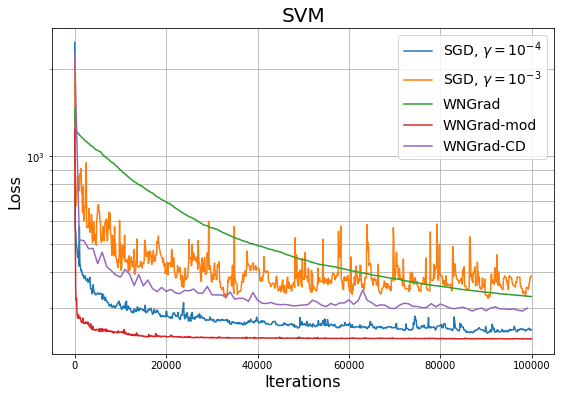

In [6]:
plt.figure(figsize = (9, 6))
fig = plt.gcf()
ax = plt.gca()
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="SGD, $\gamma = 10^{-4}$")
plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="SGD, $\gamma = 10^{-3}$")
plt.semilogy(history_wngrad_b2["iter"], history_wngrad_b2["objective_function"], label="WNGrad")
plt.semilogy(history_wngrad["iter"], history_wngrad["objective_function"], label="WNGrad-mod")
plt.semilogy(history_cd["iter"], history_cd["objective_function"], label="WNGrad-CD")
plt.grid(which = 'minor')
plt.grid(which = 'major')
plt.ylabel('Loss', fontsize = 16)
plt.xlabel('Iterations', fontsize = 16)
# plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14})
plt.title('SVM', fontsize = 20)
plt.show()
fig.savefig('SVM')

# 2. Non-convex Settings 
[Back to Index](#Index)

## 2.A Dense Neural Network
[Back to Index](#Index)

## 2.B Convolutional Neural Network
[Back to Index](#Index)

In [9]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader_1batch = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def train(optimizer, net, epochs):
    history = defaultdict(list)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            net.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if 'SGD' in str(optimizer):
                optimizer.step()
            elif 'WNGrad' in str(optimizer):
                
                # Store original parameters, and flatten params and grad
                if epoch == 0 and i == 0:
                    b_candidates = []
                    orig_param_list = []
                    grad_flat = torch.empty((0,))
                    param_flat = torch.empty((0,))
                    layers = []
                    for name, param in net.named_parameters():
                        orig_param_list.append(param)
                        grad_flat = torch.cat((grad_flat, param.grad.flatten()))
                        param_flat = torch.cat((param_flat, param.flatten()))
                        layers.append(name.split('.')[0])

                    for i in np.arange(-5, 0, 0.1):
                        for i_layer, layer in enumerate(layers):
                            if i_layer % 2 == 0: # Weight
                                getattr(net, layers[i_layer].split('.')[0]).weight = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))
                            else:
                                getattr(net, layers[i_layer].split('.')[0]).bias = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))



                        # Get gradient
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
#                         print(getattr(net, layers[i_layer].split('.')[0]).bias.grad)
                        loss.backward()

                        # Retreive gradient
                        grad_flat_temp = torch.empty((0,))
                        param_flat_temp = torch.empty((0,))
                        for name, param in net.named_parameters():
                            grad_flat_temp = torch.cat((grad_flat_temp, param.grad.flatten()))
                            param_flat_temp = torch.cat((param_flat_temp, param.flatten()))
                        
#                         print(grad_flat_temp.mean(), grad_flat.mean(), param_flat_temp.mean(), param_flat.mean(),)
                        b_candidates.append((grad_flat_temp - grad_flat).norm(2)/(param_flat_temp - param_flat).norm(2))

                        # Once initialization search is over...
                    
                    # Put originals back in place
                    for i_layer, layer in enumerate(layers):
                        if i_layer % 2 == 0: # Weight
                            getattr(net, layers[i_layer].split('.')[0]).weight = orig_param_list[i_layer]
                        else:
                            getattr(net, layers[i_layer].split('.')[0]).bias = orig_param_list[i_layer]
                    
                    # And choose a b
#                     print(b_candidates)
                    b = max(b_candidates)
#                     b = 50
                    print('Initial_b: ', b, 'Max candidates: ', sorted(b_candidates)[-2])
                    optimizer.b = b
#                     raise Exception()
                elif i % 500 == 499:
                    print('Current b:', optimizer.b)
                def closure():
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    return loss
                optimizer.step(closure)

            # print statistics
            running_loss += loss.item()
#             if i % 10 == 9:    # Store every 10 mini-batches
#                 history["iter"].append(i*(epoch+1))
#                 history["loss"].append(running_loss)
# #                 print(f'loss = {running_loss}')
# #                 print('[%d, %5d] loss: %.3f' %
# #                       (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0
            if i % 500 == 499:    # print every 2000 mini-batches
                net.eval()
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 5000))
                history["iter"].append(i+len(trainloader)*epoch+1)
                history["train loss"].append(running_loss)
                running_loss = 0.0
                total = 0
                correct = 0
                with torch.no_grad():
                    test_loss = 0
                    for data in testloader:
                        images, labels = data
                        # calculate outputs by running images through the network
                        outputs = net(images)
                        test_loss += criterion(outputs, labels)
                        
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                history["test accuracy"].append(100*correct/total)
                print(100*correct/total, '%')
                history["test loss"].append(test_loss)
#                 print('Accuracy of the network on the 10000 test images: %d %%' % (
#                     100 * correct / total))
    return history

In [14]:
# Define Criterion
epochs = 2
criterion = torch.nn.CrossEntropyLoss()
net_SGD = Net()
optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=0.001, momentum=0.9)
history = train(optimizer_SGD, net_SGD, epochs)
# Redo with WNGrad-mod
net_WNGrad = Net()
optimizer_WNGrad_mod = WNGrad(net_WNGrad.parameters())
history_WNGrad_mod = train(optimizer_WNGrad_mod, net_WNGrad, epochs)
# Redo with WNGrad
net_WNGrad = Net()
optimizer_WNGrad_bsq = WNGrad(net_WNGrad.parameters(), b_sq = True)
history_WNGrad_bsq = train(optimizer_WNGrad_bsq, net_WNGrad, epochs)

[1,   500] loss: 0.230
10.0 %
[1,  1000] loss: 0.230
13.21 %
[1,  1500] loss: 0.226
20.02 %
[1,  2000] loss: 0.214
26.25 %
[1,  2500] loss: 0.199
29.63 %
[1,  3000] loss: 0.193
31.9 %
[1,  3500] loss: 0.184
32.65 %
[1,  4000] loss: 0.178
36.81 %
[1,  4500] loss: 0.171
39.39 %
[1,  5000] loss: 0.167
39.87 %
[2,   500] loss: 0.162
42.56 %
[2,  1000] loss: 0.158
42.93 %
[2,  1500] loss: 0.158
43.8 %
[2,  2000] loss: 0.153
44.89 %
[2,  2500] loss: 0.150
44.11 %
[2,  3000] loss: 0.150
46.28 %
[2,  3500] loss: 0.150
47.15 %
[2,  4000] loss: 0.148
48.53 %
[2,  4500] loss: 0.144
47.05 %
[2,  5000] loss: 0.143
49.16 %
Initial_b:  tensor(122.6961, grad_fn=<DivBackward0>) Max candidates:  tensor(61.9420, grad_fn=<DivBackward0>)
Current b: tensor(124.4037)
[1,   500] loss: 3.892
15.95 %
Current b: tensor(126.7279)
[1,  1000] loss: 0.228
21.29 %
Current b: tensor(134.8349)
[1,  1500] loss: 0.214
24.19 %
Current b: tensor(146.1237)
[1,  2000] loss: 0.201
28.72 %
Current b: tensor(157.6402)
[1,  2500

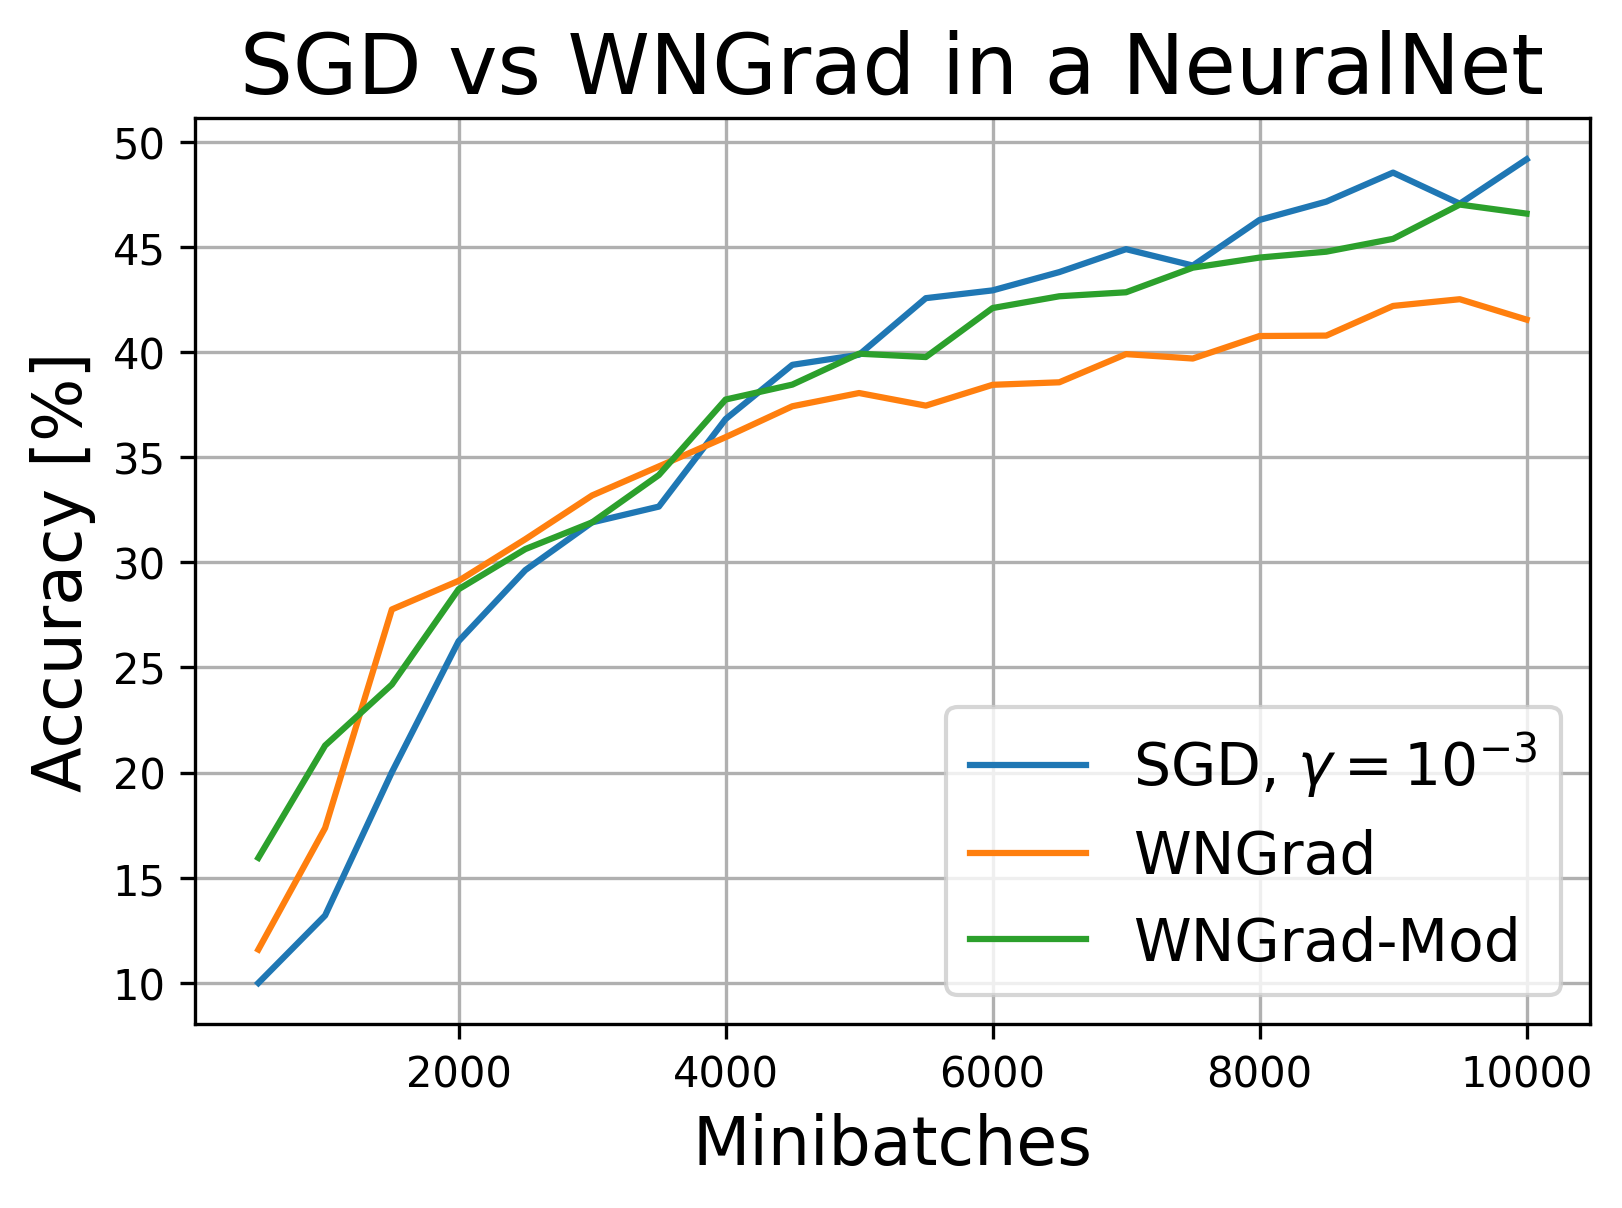

In [16]:
plt.figure()
ax = plt.gca(); ax.grid(); fig = plt.gcf()
# SGD
plt.plot(history["iter"], history["test accuracy"], label="SGD, $\gamma = 10^{-3}$")
# WNGRAD
plt.plot(history_WNGrad_bsq["iter"], history_WNGrad_bsq["test accuracy"], label="WNGrad")
# WN Grad mod
plt.plot(history_WNGrad_mod["iter"], history_WNGrad_mod["test accuracy"], label="WNGrad-Mod")
plt.xlabel('Minibatches', fontsize=16); plt.ylabel('Accuracy [%]', fontsize = 16)
plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14}); plt.title('SGD vs WNGrad in a NeuralNet', fontsize = 20)
plt.show()